# Setup and Libraries

In [1]:
# If 'KGML_ET_Partitioned.csv' is stored on Google Drive and you're using Colab,
# you need to mount your Google Drive first. Uncomment and run the following lines:

# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import math
import random
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
from scipy.stats import linregress
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score
import copy, math, random, tqdm


# Data Loading

In [3]:
# Update the path below to the folder where 'KGML_ET_Partitioned.csv' is located
df_path = '.../partitioned_data/KGML Carbon Patition Dataset.csv'
data = pd.read_csv(df_path)

# Model Definition

In [4]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA available: True
GPU: Tesla T4


In [5]:
# ==========================================================
# Updated KGML Self-Supervised with Rd & extra constraints
# ==========================================================

class KGML_SelfSup(nn.Module):
    def __init__(self, nfeat):
        super().__init__()
        # Shared encoder
        self.enc = nn.Sequential(
            nn.Linear(nfeat, 128), nn.ReLU(),
            nn.Dropout(0.1),  # MC dropout
            nn.Linear(128, 128), nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Stomatal conductance (monotone)
        self.gs_net = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1), nn.Softplus())

        # GPP head
        self.gpp_head = nn.Sequential(
            nn.Linear(128 + 1, 64), nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1)
        )


        # Respiration head (optional)
        self.r_auto_head = nn.Sequential(
            nn.Linear(128, 32), nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 2)
        )

        self.r_het_head = nn.Sequential(
            nn.Linear(128 + 2, 32), nn.ReLU(),  # use Tsoil + SM
            nn.Linear(32, 1)
        )

        # WUE prior estimator
        self.wue_hat = nn.Sequential(
            nn.Linear(4, 32), nn.Softplus(),
            nn.Linear(32, 1)
        )

        # portion og GPP in auto_above:
        self.coe_gpp_auto_abv0_raw = nn.Parameter(torch.tensor(0.0))

        # Energy conversion parameters (ET from LE)
        self.alpha0 = nn.Parameter(torch.tensor(0.0))
        self.alpha1 = nn.Parameter(torch.tensor(1.0))

        # Medlyn slope (optional)
        self.beta_medlyn = nn.Parameter(torch.tensor(1.0))

        # ET latent scaling
        self.tlat_mult = nn.Parameter(torch.tensor(1.2))
        self.tlat_beta = 0.6

    def forward(self, X, idx_map):
        z = self.enc(X)

        # --- Drivers ---
        PAR  = X[:, [idx_map['PAR_NEON']]]
        SM   = X[:, [idx_map['SoilMoisture_NEON']]]
        VPD  = X[:, [idx_map['vpd_NEON']]]
        LE   = X[:, [idx_map['LE']]]
        Tair = X[:, [idx_map['AirTemperature_NEON']]]
        Tsoil = X[:, [idx_map['T_soil1to4']]]
        SW_in  = X[:, [idx_map['SW_IN']]]
        SW_out = X[:, [idx_map['SW_OUT']]]
        LW_in  = X[:, [idx_map['LW_IN']]]
        LW_out = X[:, [idx_map['LW_OUT']]]
        H      = X[:, [idx_map['H']]]
        G      = X[:, [idx_map['G_1to5']]]
        NEE_PI = X[:, [idx_map['NEE_PI']]]
        Pfvs_obs = X[:, [idx_map['Pfvs_NEON']]]
        Rfvs_obs = X[:, [idx_map['Rfvs_NEON']]]
        Tfvs_obs = X[:, [idx_map['Tfvs_NEON']]]
        Tair = X[:, [idx_map['AirTemperature_NEON']]]

        # --- Stomatal conductance ---
        gs = self.gs_net(z) # (torch.cat([PAR, SM, Tfvs_obs], -1)) #
        gs = torch.clamp(gs, min=0.0)

        # --- GPP ---
        GPP = F.softplus(self.gpp_head(torch.cat([z, gs], -1)))
        GPP = torch.clamp(GPP, min=0.0)

        # --- Respiration ---
        coe_gpp_auto_abv0 = 0.05 + 0.68 * torch.sigmoid(self.coe_gpp_auto_abv0_raw)
        R_auto_above, R_auto_below = F.softplus(self.r_auto_head(z)).chunk(2, dim=-1)
        R_auto_above = R_auto_above + coe_gpp_auto_abv0 * GPP
        R_auto = R_auto_above + R_auto_below #+ 0.35 * GPP

        # Heterotrophic respiration depends on soil temp + moisture
        R_het = F.softplus(self.r_het_head(torch.cat([z, Tsoil, SM], -1)))

        # RECO
        R_het = R_het * torch.exp(torch.log(torch.tensor(2.0)) * (Tsoil - 15.0)/10.0)
        RECO = R_auto + R_het

        # --- ET latent flux ---
        eps = 1e-5
        T_lat = F.softplus(self.tlat_mult * gs * (VPD + eps), beta=self.tlat_beta)
        ET_lat = T_lat + 0.05 * F.softplus(PAR)

        # --- WUE prior ---
        WUE_hat = self.wue_hat(torch.cat([VPD, Tfvs_obs, Tair, SM], -1))

        # --- LE → ET ---
        ET_from_LE = self.alpha0 + self.alpha1 * (LE / 2.45e6)

        # --- NEE ---
        NEE_pred = RECO - GPP

        # --- Carbon efflux composites ---
        Pfvs_pred = GPP - R_auto_above
        Rfvs_pred = R_auto_below + R_het

        # --- Energy balance ---
        Rn = (SW_in - SW_out) + (LW_in - LW_out)
        L_heat = ET_lat #* 2.45e-6
        L_energy_balance = Rn - (L_heat + H + G)
        L_energy = torch.mean(torch.abs(L_energy_balance) / torch.clamp(torch.abs(Rn), min=1e-6))

        return {
            'GPP': GPP,
            'RECO': RECO,
            'R_auto': R_auto,
            'R_auto_above': R_auto_above,
            'R_auto_below': R_auto_below,
            'R_hetero': R_het,
            'gs': gs,
            'T_lat': T_lat,
            'ET_lat': ET_lat,
            'WUE_hat': WUE_hat,
            'ET_LE': ET_from_LE,
            'NEE_pred': NEE_pred,
            'Pfvs_pred': Pfvs_pred,
            'Rfvs_pred': Rfvs_pred,
            'L_energy_balance': L_energy_balance
        }


# -----------------------
# Updated loss function
# -----------------------
def self_supervised_loss(out, X_batch, idx_map, weights):
    get = lambda k: X_batch[:, idx_map[k]:idx_map[k]+1]
    PAR   = get('PAR_NEON')
    SM    = get('SoilMoisture_NEON')
    VPD   = get('vpd_NEON')
    LE    = get('LE')
    Tair  = get('AirTemperature_NEON')
    NEE_PI = get('NEE_PI')
    Pfvs_obs = get('Pfvs_NEON')
    Rfvs_obs = get('Rfvs_NEON')
    Tfvs_obs = get('Tfvs_NEON')

    eps = 1e-4

    # --- WUE ---
    WUE_pred = out['GPP'] / torch.clamp(out['T_lat'], min=eps)
    L_WUE = torch.mean(torch.abs(WUE_pred - out['WUE_hat']))

    # --- Medlyn ---
    med_model = out['gs'] * (PAR / torch.sqrt(torch.clamp(VPD, min=eps)))
    L_Med = torch.mean(torch.abs(out['GPP'] - med_model * torch.sigmoid(out['WUE_hat']*0.1) * (1.0 + 0.01*Tair)))

    # --- ET closure ---
    L_eng = torch.mean(torch.abs(out['ET_lat'] - out['ET_LE']))

    # --- NEE ---
    L_NEE_abs  = torch.mean((torch.abs(NEE_PI) - torch.abs(out['NEE_pred']))**2)
    L_NEE_sign = torch.mean((out['NEE_pred'] - NEE_PI)**2)

    # --- Night GPP suppression ---
    night_mask = (PAR > 0.001).float()
    L_night = torch.mean((1.0 - night_mask) * out['GPP'])

    # --- Pfvs/Rfvs ---
    L_Pfvs = torch.mean(torch.abs(out['Pfvs_pred'] - Pfvs_obs))
    L_Rfvs = torch.mean(torch.abs(out['Rfvs_pred'] - Rfvs_obs))

    # gs relationships
    # Constants
    cp_gs = 1010.0         # J kg-1 K-1
    Mw_gs = 18e-3          # kg mol-1
    R_gs = 8.314           # J mol-1 K-1
    P_gs = 101325          # Pa, assume sea level
    LE_gs = LE                        # W m-2
    Tair_gs = Tair + 273.15   # K
    VPD_gs = VPD * 1000           # kPa → Pa

    lambda_v_gs = (2.501 - 0.00237 * (Tair_gs - 273.15)) * 1e6 # Latent heat of vaporization (J kg-1)
    rho_gs = P_gs / (R_gs / Mw_gs * Tair_gs)            # Air density # kg m-3
    gamma_gs = cp_gs * P_gs / (0.622 * lambda_v_gs)  # Psychrometric constant # Pa K-1
    gs_m_s_gs = (LE_gs * gamma_gs) / (rho_gs * cp_gs * VPD_gs) # Surface conductance (m s-1)
    gs_mol_gs = gs_m_s_gs * P_gs / (R_gs * Tair_gs) # Convert to mol m-2 s-1
    L_gs = torch.mean(torch.abs(out['gs'] - gs_mol_gs))

    loss = (
        weights['WUE']      * L_WUE +
        weights['Med']      * L_Med +
        weights['ENG']      * L_eng +
        weights['NEE_sign'] * L_NEE_sign +
        weights['NEE_abs']  * L_NEE_abs +
        weights['NIGHT']    * L_night +
        weights['Pfvs']     * L_Pfvs +
        weights['Rfvs']     * L_Rfvs
    )

    stats = {
        'L_WUE': L_WUE.item(),
        'L_Med': L_Med.item(),
        'L_NEE_abs': L_NEE_abs.item(),
        'L_NEE_sign': L_NEE_sign.item(),
        'L_night': L_night.item(),
        'L_Pfvs': L_Pfvs.item(),
        'L_Rfvs': L_Rfvs.item(),
        }
    return loss, stats


# Training

In [6]:
# =========================
# Ready-to-run KGML Training
# =========================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import pandas as pd

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 27
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

# -----------------------
# Data preparation
# -----------------------
df = data.copy()  # your pandas DataFrame
ceaComponants = ['Tcea_NEON', 'Pcea_NEON', 'Ecea_NEON', 'Rcea_NEON', 'ETcea_NEON']
REQUIRED_COLS = ['LE', 'H', 'USTAR', 'SW_IN', 'SW_OUT', 'LW_IN', 'LW_OUT', 'T_soil1to4', 'G_1to5',
    'SoilMoisture_NEON', 'AirTemperature_NEON', 'SolarRadIn_NEON', 'RH_NEON',
    'PAR_NEON', 'fluxTemp_NEON', 'ustar_NEON', 'WindSpeed_NEON', 'vpd_NEON',
    'NEE_PI', 'Tfvs_NEON', 'Pfvs_NEON', 'Efvs_NEON', 'Rfvs_NEON', 'ETfvs_NEON',
    'CO2_MIXING_RATIO_1_1_1']

# Ensure 'hour' and 'doy' exist
if 'hour' not in df.columns:
    df['hour'] = pd.to_datetime(df.index).hour if isinstance(df.index, pd.DatetimeIndex) else 12
if 'doy' not in df.columns:
    df['doy'] = pd.to_datetime(df.index).dayofyear if isinstance(df.index, pd.DatetimeIndex) else 180

print(df.shape)
df = df[REQUIRED_COLS + ['hour', 'doy']+ ceaComponants].dropna().copy()

# Clip extremes
df = df.clip(lower=df.quantile(0.000001), upper=df.quantile(0.999999), axis=1)

# Column index map
col_index = {c: i for i, c in enumerate(df.columns)}

# Torch tensors
X_np = df.values.astype(np.float32)
X = torch.from_numpy(X_np).to(DEVICE)

# -----------------------
# Instantiate model & optimizer
# -----------------------
nfeat = X.shape[1]
model = KGML_SelfSup(nfeat).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# -----------------------
# # Loss weights
# # -----------------------

weights = {
    'WUE': 0.3,       # keep
    'Med': 0.2,       # keep
    'ENG': 0.1,       # reduce slightly, if energy is dominating
    'NEE_sign': 0.36,  # increase for better carbon flux tracking
    'NEE_abs': 0.36,   # increase
    'NIGHT': 0.1,     # keep
    'Pfvs': 0.15,      # increase to enforce partitioning
    'Rfvs': 0.3,      # increase to enforce partitioning
    'R_ratio': 0.05,  # optional soft guidance
    'GPP_max': 0.05,   # optional soft guidance
    'gs': 0.2
}


# -----------------------
# Training loop
# -----------------------
EPOCHS = 2300
loss_history, stat_history = [], []

model.train()
for epoch in range(EPOCHS):
    out = model(X, col_index)

    # Optional: soft ratio constraint
    eps = 1e-6
    R_auto_total = out['R_auto_above'] + out['R_auto_below']
    target_ratio = 0.6
    L_R_ratio = torch.mean((out['R_auto_above'] / (R_auto_total + eps) - target_ratio)**2)

    # Optional: soft GPP max
    PAR = X[:, [col_index['PAR_NEON']]]
    GPP_max = PAR * 0.05
    L_GPP_max = torch.mean(F.relu(out['GPP'] - GPP_max))

    # Compute main loss
    loss, stats = self_supervised_loss(out, X, col_index, weights)

    # Add optional terms
    loss = loss + weights['R_ratio'] * L_R_ratio + weights['GPP_max'] * L_GPP_max

    opt.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
    opt.step()

    loss_history.append(loss.item())
    stats.update({'L_R_ratio': L_R_ratio.item(), 'L_GPP_max': L_GPP_max.item()})
    stat_history.append(stats)

    if (epoch+1) % 200 == 0 or epoch < 2:
        print(f"Epoch {epoch+1}/{EPOCHS} | loss={loss.item():.5f} | stats={stats}")

# -----------------------
# Evaluation
# -----------------------
model.eval()
with torch.no_grad():
    out_all = model(X, col_index)
    results = {k: v.detach().cpu().numpy().flatten() for k, v in out_all.items()}

df_out = df.copy().reset_index(drop=True)
for k, v in results.items():
    df_out[k] = v



(101144, 53)
Epoch 1/2300 | loss=368.81470 | stats={'L_WUE': 17.125391006469727, 'L_Med': 272.8763122558594, 'L_NEE_abs': 286.0528869628906, 'L_NEE_sign': 547.9601440429688, 'L_night': 0.030126458033919334, 'L_Pfvs': 0.7535751461982727, 'L_Rfvs': 12.958198547363281, 'L_R_ratio': 0.2770155072212219, 'L_GPP_max': 0.13177520036697388}
Epoch 2/2300 | loss=40.79581 | stats={'L_WUE': 14.526897430419922, 'L_Med': 4.210721969604492, 'L_NEE_abs': 34.8958625793457, 'L_NEE_sign': 48.944244384765625, 'L_night': 0.06568942964076996, 'L_Pfvs': 2.0943918228149414, 'L_Rfvs': 0.8921799659729004, 'L_R_ratio': 0.1572316586971283, 'L_GPP_max': 0.2964177429676056}
Epoch 200/2300 | loss=12.93739 | stats={'L_WUE': 1.9053815603256226, 'L_Med': 2.407836675643921, 'L_NEE_abs': 8.851517677307129, 'L_NEE_sign': 9.577129364013672, 'L_night': 0.0008811393636278808, 'L_Pfvs': 2.3938984870910645, 'L_Rfvs': 0.3293774724006653, 'L_R_ratio': 0.1549605280160904, 'L_GPP_max': 0.003590043168514967}
Epoch 400/2300 | loss=9.

# Monte Carlo Dropout Predictions

In [7]:
# ================================
# MC Dropout Prediction Function (Batched, fix 2D issue)
# ================================
def mc_dropout_predictions_batched(model, X, col_index, n_samples=100, batch_size=1024, device='cuda'):
    """
    Run Monte Carlo dropout for uncertainty estimation using batches to avoid GPU OOM.
    Returns mean, lower, upper (90% CI) for GPP and RECO.
    """
    model.train()  # keep dropout active

    n_points = X.shape[0]
    preds_GPP = np.zeros((n_samples, n_points), dtype=np.float32)
    preds_RECO = np.zeros((n_samples, n_points), dtype=np.float32)

    for b_start in range(0, n_points, batch_size):
        b_end = min(b_start + batch_size, n_points)
        X_batch = X[b_start:b_end].to(device)

        for s in range(n_samples):
            with torch.no_grad():
                out = model(X_batch, col_index)
                # flatten batch outputs to 1D
                preds_GPP[s, b_start:b_end] = out['GPP'].cpu().numpy().flatten()
                preds_RECO[s, b_start:b_end] = out['RECO'].cpu().numpy().flatten()

    # Compute mean and 90% CI
    GPP_mean = preds_GPP.mean(axis=0)
    GPP_lower = np.percentile(preds_GPP, 5, axis=0)
    GPP_upper = np.percentile(preds_GPP, 95, axis=0)

    RECO_mean = preds_RECO.mean(axis=0)
    RECO_lower = np.percentile(preds_RECO, 5, axis=0)
    RECO_upper = np.percentile(preds_RECO, 95, axis=0)

    return {
        'GPP_mean': GPP_mean,
        'GPP_lower': GPP_lower,
        'GPP_upper': GPP_upper,
        'RECO_mean': RECO_mean,
        'RECO_lower': RECO_lower,
        'RECO_upper': RECO_upper
    }


preds = mc_dropout_predictions_batched(model, X, col_index, n_samples=100, batch_size=1024)

GPP_obs = df_out['GPP'].values
RECO_obs = df_out['RECO'].values

GPP_covered = np.mean((GPP_obs >= preds['GPP_lower']) & (GPP_obs <= preds['GPP_upper']))
RECO_covered = np.mean((RECO_obs >= preds['RECO_lower']) & (RECO_obs <= preds['RECO_upper']))

print(f"90% coverage probability for GPP: {GPP_covered*100:.1f}%")
print(f"90% coverage probability for RECO: {RECO_covered*100:.1f}%")


90% coverage probability for GPP: 95.2%
90% coverage probability for RECO: 95.8%


# Visualizations

In [9]:
# Assuming df_plot (observed/input) and df_out_plot (KGML predictions) are ready
# Make sure your df_out and df have numeric columns only
features = REQUIRED_COLS
df_plot = data.copy().reset_index(drop=True)
df_plot = df_plot[features+['Site Id', 'TIMESTAMP_END', 'GPP_np', 'RECO_np']].copy()
df_plot = df_plot.dropna(subset=features)
df_plot['GPP_mean'] = preds['GPP_mean']; df_plot['GPP_lower'] = preds['GPP_lower']; df_plot['GPP_upper'] = preds['GPP_upper']
df_plot['RECO_mean'] = preds['RECO_mean']; df_plot['RECO_lower'] = preds['RECO_lower']; df_plot['RECO_upper'] = preds['RECO_upper']
df_out_plot = df_out.copy().reset_index(drop=True)
df_out_plot['GPP_mean'] = preds['GPP_mean']; df_out_plot['GPP_lower'] = preds['GPP_lower']; df_out_plot['GPP_upper'] = preds['GPP_upper']
df_out_plot['RECO_mean'] = preds['RECO_mean']; df_out_plot['RECO_lower'] = preds['RECO_lower']; df_out_plot['RECO_upper'] = preds['RECO_upper']
print(df_plot.shape, df_out_plot.shape)

(101144, 35) (101144, 53)


In [10]:
print(df_plot.shape)
print(df_out_plot.shape)
# Example: remove rows above 999th percentile
threshold = df_out_plot['RECO'].quantile(0.9997)
mask = (df_out_plot['RECO'] <= threshold).to_numpy()
df_plot = df_plot[mask].reset_index(drop=True)
df_out_plot = df_out_plot[mask].reset_index(drop=True)
print(df_plot.shape, df_out_plot.shape)

(101144, 35)
(101144, 53)
(101113, 35) (101113, 53)


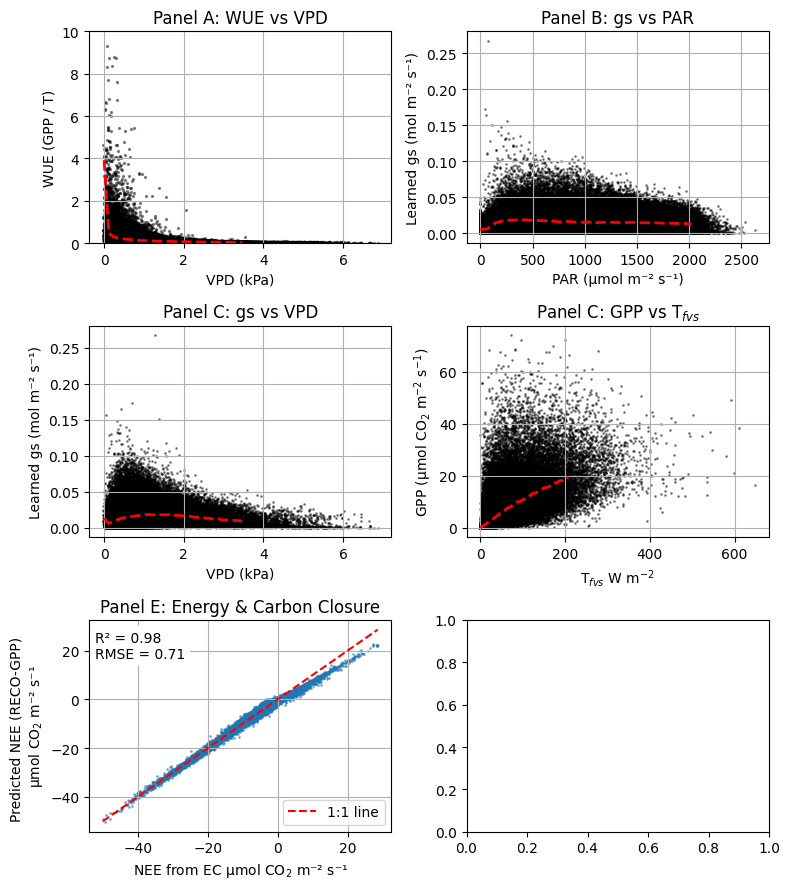

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(8, 9))  # 3 rows, 2 columns

# ---------------- Panel A: WUE vs VPD ----------------
WUE_vals = df_out_plot['GPP'].values / (df_plot['Tfvs_NEON'].values + 1e-6)
bins_par = np.linspace(0, np.percentile(df_plot['vpd_NEON'].values, 98), 30)
digit_par = np.digitize(df_plot['vpd_NEON'].values, bins_par)
med_gs = [np.nanmean(WUE_vals[digit_par == i]) if np.any(digit_par == i) else np.nan for i in range(len(bins_par)+1)]
axs[0,0].scatter(df_plot['vpd_NEON'].values, WUE_vals, s=2, color='black', alpha=0.4)
axs[0,0].plot(bins_par, np.nan_to_num(med_gs[:len(bins_par)]), 'r--', linewidth=2)
axs[0,0].set_ylim([0, 10])
axs[0,0].set_xlabel('VPD (kPa)')
axs[0,0].set_ylabel('WUE (GPP / T)')
axs[0,0].set_title('Panel A: WUE vs VPD')
axs[0,0].grid(True)

# ---------------- Panel B: gs vs PAR ----------------
bins_par = np.linspace(0, np.percentile(df_plot['PAR_NEON'].values, 98), 30)
digit_par = np.digitize(df_plot['PAR_NEON'].values, bins_par)
med_gs = [np.nanmean(df_out_plot['gs'].values[digit_par == i]) if np.any(digit_par == i) else np.nan for i in range(len(bins_par)+1)]
axs[0,1].scatter(df_plot['PAR_NEON'].values, df_out_plot['gs'].values, s=1, color='black', alpha=0.4)
axs[0,1].plot(bins_par, np.nan_to_num(med_gs[:len(bins_par)]), 'r--', linewidth=2)
axs[0,1].set_xlabel('PAR (µmol m⁻² s⁻¹)')
axs[0,1].set_ylabel('Learned gs (mol m⁻² s⁻¹)')
axs[0,1].set_title('Panel B: gs vs PAR')
axs[0,1].grid(True)

# ---------------- Panel C: gs vs VPD ----------------
bins_par = np.linspace(0, np.percentile(df_plot['vpd_NEON'].values, 98), 30)
digit_par = np.digitize(df_plot['vpd_NEON'].values, bins_par)
med_gs = [np.nanmean(df_out_plot['gs'].values[digit_par == i]) if np.any(digit_par == i) else np.nan for i in range(len(bins_par)+1)]
axs[1,0].scatter(df_plot['vpd_NEON'].values, df_out_plot['gs'].values, s=1, color='black', alpha=0.4)
axs[1,0].plot(bins_par, np.nan_to_num(med_gs[:len(bins_par)]), 'r--', linewidth=2)
axs[1,0].set_xlabel('VPD (kPa)')
axs[1,0].set_ylabel('Learned gs (mol m⁻² s⁻¹)')
axs[1,0].set_title('Panel C: gs vs VPD')
axs[1,0].grid(True)

# ---------------- Panel D: ET Closure ----------------
# Define bins based on Tfvs_NEON instead of VPD
bins_par = np.linspace(0, np.percentile(df_plot['Tfvs_NEON'].values, 98), 30)
digit_par = np.digitize(df_plot['Tfvs_NEON'].values, bins_par)
med_gpp = [np.nanmean(df_out_plot['GPP'].values[digit_par == i]) if np.any(digit_par == i) else np.nan for i in range(len(bins_par)+1)]
axs[1,1].scatter(df_plot['Tfvs_NEON'].values, df_out_plot['GPP'].values, s=1, color='black', alpha=0.4)
# Plot median relationship
axs[1,1].plot(bins_par, np.nan_to_num(med_gpp[:len(bins_par)]), 'r--', linewidth=2)
axs[1,1].set_xlabel('T$_{fvs}$ W m$^{-2}$')
axs[1,1].set_ylabel('GPP (μmol CO$_2$ m$^{-2}$ s$^{-1}$)')
axs[1,1].set_title('Panel C: GPP vs T$_{fvs}$')
axs[1,1].grid(True)

# ---------------- Panel E: Energy & carbon closure ----------------
NEE_pred = df_out_plot['RECO'].values - df_out_plot['GPP'].values
NEE_obs = df_plot['NEE_PI'].values
axs[2,0].scatter(NEE_obs, NEE_pred, s=1, alpha=0.5)
axs[2,0].plot([NEE_obs.min(), NEE_obs.max()], [NEE_obs.min(), NEE_obs.max()], 'r--', label='1:1 line')
axs[2,0].set_xlabel('NEE from EC µmol CO$_2$ m⁻² s⁻¹')
axs[2,0].set_ylabel('Predicted NEE (RECO-GPP) \nµmol CO$_2$ m⁻² s⁻¹')
axs[2,0].set_title('Panel E: Energy & Carbon Closure')
axs[2,0].legend()
axs[2,0].grid(True)
axs[2,0].text(0.02, 0.95, f'R² = {r2_score(NEE_obs, NEE_pred):.2f}\nRMSE = {np.sqrt(mean_squared_error(NEE_obs, NEE_pred)):.2f}',
            transform=axs[2,0].transAxes, va='top', bbox=dict(boxstyle="round", facecolor="white", edgecolor="white"))


plt.tight_layout()
# plt.savefig('fig1_physical_consistency.png', dpi=500)
plt.show()


In [ ]:
x = df_plot['GPP_np'].values
y = df_out_plot['GPP'].values
plt.hexbin(x, y, gridsize=200, cmap='inferno', mincnt=1, bins='log')
plt.plot([0, 70], [0, 70], 'k--')
plt.xlabel('nighttime GPP (µmol CO$_2$ m$^{-2}$ s$^{-1}$)')
plt.ylabel('KGML GPP (µmol CO$_2$ m$^{-2}$ s$^{-1}$)')
plt.title('GPP Hexbin Plot')
plt.colorbar(label='Count')
mask = ~np.isnan(x) & ~np.isnan(y)
x_clean = x[mask]; y_clean = y[mask]
slope, intercept, r_value, _, _ = linregress(x_clean, y_clean)
fit_line = slope * x_clean + intercept
plt.plot(x_clean, fit_line, 'b-', label=f'y={slope:.2f}x+{intercept:.1f}')
plt.show()

x = df_plot['RECO_np'].values
y = df_out_plot['RECO'].values
plt.hexbin(x, y, gridsize=200, cmap='inferno', mincnt=1, bins='log')
plt.plot([0, 30], [0, 30], 'k--')
plt.xlabel('nighttime RECO (µmol CO$_2$ m$^{-2}$ s$^{-1}$)')
plt.ylabel('KGML RECO (µmol CO$_2$ m$^{-2}$ s$^{-1}$)')
plt.title('RECO Hexbin Plot')
plt.colorbar(label='Count')
mask = ~np.isnan(x) & ~np.isnan(y)
x_clean = x[mask]; y_clean = y[mask]
slope, intercept, r_value, _, _ = linregress(x_clean, y_clean)
fit_line = slope * x_clean + intercept
plt.plot(x_clean, fit_line, 'b-', label=f'y={slope:.2f}x+{intercept:.1f}')
plt.show()




In [ ]:
# ======= SHAP Feature Importance for KGML =======
import shap

DEVICE = next(model.parameters()).device

# ---- Prediction wrappers for SHAP -----------------
def predict_gpp_numpy(X_numpy):
    xt = torch.from_numpy(X_numpy.astype(np.float32)).to(DEVICE)
    out = model(xt, col_index)
    return out['GPP'].detach().cpu().numpy().flatten()

def predict_reco_numpy(X_numpy):
    xt = torch.from_numpy(X_numpy.astype(np.float32)).to(DEVICE)
    out = model(xt, col_index)
    return out['RECO'].detach().cpu().numpy().flatten()

# ---- Subsample for background and explanation ----
bg_idx = np.random.choice(np.arange(X.shape[0]), size=min(100, X.shape[0]), replace=False)
X_bg = X[bg_idx].cpu().numpy()

expl_idx = np.random.choice(np.setdiff1d(np.arange(X.shape[0]), bg_idx),
                            size=min(2000, X.shape[0]-len(bg_idx)), replace=False)
X_explain = X[expl_idx].cpu().numpy()

# ---- Run SHAP KernelExplainer -------------------
print("Running SHAP KernelExplainer for GPP (this may take a while)...")
explainer_gpp = shap.KernelExplainer(predict_gpp_numpy, X_bg)
shap_vals_gpp = explainer_gpp.shap_values(X_explain, nsamples=2000)

print("Running SHAP KernelExplainer for RECO (this may take a while)...")
explainer_reco = shap.KernelExplainer(predict_reco_numpy, X_bg)
shap_vals_reco = explainer_reco.shap_values(X_explain, nsamples=2000)

# ---- Aggregate absolute mean importance per feature ----
feat_names = [name.replace("_NEON", "") for name in df.columns]
feat_names = feat_names
mean_abs_shap_gpp = np.mean(np.abs(shap_vals_gpp), axis=0)
mean_abs_shap_reco = np.mean(np.abs(shap_vals_reco), axis=0)

# ---- Plot SHAP summary ----------------------------
fig = shap.summary_plot(shap_vals_gpp, X_explain, feature_names=feat_names, show=False, plot_size=(6, 5))
plt.tight_layout()
plt.show()

shap.summary_plot(shap_vals_reco, X_explain, feature_names=feat_names, show=False, plot_size=(6, 5))
plt.tight_layout()
plt.show()

In [ ]:
from collections import defaultdict
from tqdm import tqdm

# ----------------------
# User parameters
# ----------------------
batch_size = 256          # batch size for gradient accumulation (reduce if OOM)
max_batches = None        # set to int to limit number of batches (for speed/testing)
use_subsample_seed = 42   # seed for deterministic subsampling if max_batches set
normalize_by_params = True  # divide per-term norm by sqrt(num_params) (optional)
save_csv = True
csv_name = "physical_gradient_importance.csv"

# ----------------------
# Helpers: recompute loss terms (match your self_supervised_loss)
# ----------------------
def compute_loss_terms(model_obj, X_batch, idx_map, weights=None):
    """
    Runs forward pass and recomputes separate loss term tensors (not averaged scalars)
    Returns: dict of torch scalar tensors (requires_grad=True)
    """
    eps = 1e-4
    device = X_batch.device

    # Forward
    out = model_obj(X_batch, idx_map)

    # Get drivers / obs
    get = lambda k: X_batch[:, idx_map[k]:idx_map[k]+1]
    PAR   = get('PAR_NEON')
    SM    = get('SoilMoisture_NEON')
    VPD   = get('vpd_NEON')
    LE    = get('LE')
    Tair  = get('AirTemperature_NEON')
    NEE_PI = get('NEE_PI') if 'NEE_PI' in idx_map else None
    Pfvs_obs = get('Pfvs_NEON') if 'Pfvs_NEON' in idx_map else None
    Rfvs_obs = get('Rfvs_NEON') if 'Rfvs_NEON' in idx_map else None
    Tfvs_obs = get('Tfvs_NEON') if 'Tfvs_NEON' in idx_map else None

    # --- WUE ---
    # avoid division by zero
    T_lat = out['T_lat'] + 1e-8
    WUE_pred = out['GPP'] / torch.clamp(T_lat, min=eps)
    WUE_hat = out['WUE_hat']
    L_WUE = torch.mean(torch.abs(WUE_pred - WUE_hat))

    # --- Medlyn-like ---
    med_model = out['gs'] * (PAR / torch.sqrt(torch.clamp(VPD, min=eps)))
    # replicate sigmoid(WUE_hat*0.1)*(1+0.01*Tair) factor
    med_factor = torch.sigmoid(out['WUE_hat'] * 0.1) * (1.0 + 0.01 * Tair)
    L_Med = torch.mean(torch.abs(out['GPP'] - med_model * med_factor))

    # --- ET closure / energy ---
    # ET_lat is computed already in forward; ET_from_LE too
    L_eng = torch.mean(torch.abs(out['ET_lat'] - out['ET_LE']))

    # --- NEE ---
    if NEE_PI is not None:
        L_NEE_abs  = torch.mean((torch.abs(NEE_PI) - torch.abs(out['NEE_pred']))**2)
        L_NEE_sign = torch.mean((out['NEE_pred'] - NEE_PI)**2)
    else:
        # fallback zeros if NEE not present
        L_NEE_abs = torch.tensor(0.0, device=device, requires_grad=True)
        L_NEE_sign = torch.tensor(0.0, device=device, requires_grad=True)

    # --- Night GPP suppression ---
    night_mask = (PAR > 0.001).float()
    L_night = torch.mean((1.0 - night_mask) * out['GPP'])

    # --- Pfvs/Rfvs ---
    if Pfvs_obs is not None:
        L_Pfvs = torch.mean(torch.abs(out['Pfvs_pred'] - Pfvs_obs))
    else:
        L_Pfvs = torch.tensor(0.0, device=device, requires_grad=True)
    if Rfvs_obs is not None:
        L_Rfvs = torch.mean(torch.abs(out['Rfvs_pred'] - Rfvs_obs))
    else:
        L_Rfvs = torch.tensor(0.0, device=device, requires_grad=True)

    # --- Optional soft terms computed in training loop ---
    # R_ratio: fraction of autotrophic above / total
    R_auto_above = out['R_auto_above']
    R_auto_below = out['R_auto_below']
    R_auto_total = R_auto_above + R_auto_below
    eps2 = 1e-6
    L_R_ratio = torch.mean((R_auto_above / (R_auto_total + eps2) - 0.6)**2)

    # GPP_max: simple ceiling based on PAR
    GPP_max = PAR * 0.05
    L_GPP_max = torch.mean(F.relu(out['GPP'] - GPP_max))

    # Compose dictionary (each is a scalar tensor, requires_grad True)
    terms = {
        'WUE'      : L_WUE,
        'Med'      : L_Med,
        'ENG'      : L_eng,
        'NEE_abs'  : L_NEE_abs,
        'NEE_sign' : L_NEE_sign,
        'NIGHT'    : L_night,
        'Pfvs'     : L_Pfvs,
        'Rfvs'     : L_Rfvs,
        'R_ratio'  : L_R_ratio,
        'GPP_max'  : L_GPP_max
    }

    return terms

# ----------------------
# Gradient-norm computation
# ----------------------
def grad_norm_of_term(term_tensor, model_obj):
    """
    Compute L2 norm of gradients of term_tensor wrt model parameters.
    Uses torch.autograd.grad to avoid modifying .grad attributes.
    """
    params = [p for p in model_obj.parameters() if p.requires_grad]
    grads = torch.autograd.grad(term_tensor, params, retain_graph=True, create_graph=False, allow_unused=True)
    # grads may contain None for unused params
    sq = 0.0
    cnt = 0
    for g in grads:
        if g is None:
            continue
        sq = sq + torch.sum(g.detach()**2)
        cnt += int(g.numel())
    # return sqrt(sum squares) and also param count
    return torch.sqrt(sq).item(), cnt

# ----------------------
# Main loop over dataset batches
# ----------------------
model.eval()  # evaluation mode (we're not training here)
N = X.shape[0]
indices = np.arange(N)

# optional subsample for speed
if max_batches is not None:
    rng = np.random.RandomState(use_subsample_seed)
    rng.shuffle(indices)

batch_indices_list = []
start = 0
bcount = 0
while start < N:
    if max_batches is not None and bcount >= max_batches:
        break
    end = min(start + batch_size, N)
    batch_indices_list.append(indices[start:end])
    start = end
    bcount += 1

print(f"Computing gradient norms over {len(batch_indices_list)} batches (batch_size={batch_size}).")

# accumulators
term_sums = defaultdict(float)
term_counts = defaultdict(int)
param_counts = None
total_loss_grad_sums = 0.0
total_loss_param_count = 0

# important: ensure model parameters have grad enabled
for batch_idx in tqdm(batch_indices_list):
    X_batch = X[batch_idx].to(DEVICE)
    # compute terms
    terms = compute_loss_terms(model, X_batch, col_index, weights=None)

    # compute gradient norms for each term
    for name, tensor in terms.items():
        # ensure tensor is a scalar; if zero-tensor created without grad, make it a proper tensor requiring grad
        if not tensor.requires_grad:
            tensor = tensor.clone().detach().requires_grad_(True)
        try:
            gnorm, pcount = grad_norm_of_term(tensor, model)
        except RuntimeError as e:
            # fallback: compute backward on scalar and read .grad (less preferred)
            model.zero_grad()
            tensor.backward(retain_graph=True)
            sq = 0.0; pcount = 0
            for p in model.parameters():
                if p.grad is None:
                    continue
                sq += torch.sum(p.grad.detach()**2).item()
                pcount += int(p.grad.numel())
            gnorm = math.sqrt(sq)
            model.zero_grad()

        term_sums[name] += gnorm
        term_counts[name] += 1
        if param_counts is None:
            total_loss_param_count = pcount

    # For reference, compute total loss gradient norm (sum of weighted terms using current weights in your training)
    # Use your training `weights` dict if available, else use 1.0 for each term
    # Compose total loss as weighted sum
    use_weights = {
        'WUE': 0.3, 'Med':0.2, 'ENG':0.1, 'NEE_sign':0.36, 'NEE_abs':0.36,
        'NIGHT':0.1, 'Pfvs':0.15, 'Rfvs':0.3, 'R_ratio':0.05, 'GPP_max':0.05
    }
    total_loss = None
    for k, t in terms.items():
        w = use_weights.get(k, 0.0)
        if total_loss is None:
            total_loss = w * t
        else:
            total_loss = total_loss + w * t
    if total_loss is None:
        continue
    if not total_loss.requires_grad:
        total_loss = total_loss.clone().detach().requires_grad_(True)
    try:
        total_gnorm, pcount = grad_norm_of_term(total_loss, model)
    except RuntimeError:
        model.zero_grad()
        total_loss.backward()
        sq = 0.0; pcount = 0
        for p in model.parameters():
            if p.grad is None: continue
            sq += torch.sum(p.grad.detach()**2).item()
            pcount += int(p.grad.numel())
        total_gnorm = math.sqrt(sq)
        model.zero_grad()
    total_loss_grad_sums += total_gnorm

# ----------------------
# Aggregate and normalize results
# ----------------------
mean_gnorm = {}
for k in term_sums:
    mean = term_sums[k] / term_counts[k]
    mean_gnorm[k] = mean

# include total loss mean grad norm (for reference)
mean_total_gnorm = total_loss_grad_sums / max(1, len(batch_indices_list))

# Normalize importance: divide by sum to get percentages
vals = np.array([mean_gnorm[k] for k in mean_gnorm])
if np.sum(vals) == 0:
    norm_vals = np.zeros_like(vals)
else:
    norm_vals = vals / np.sum(vals)

# optional param-count normalization
if normalize_by_params and total_loss_param_count is not None and total_loss_param_count > 0:
    # divide each mean by sqrt(param_count) as a notional normalization (param_count identical for all terms here)
    pass  # param_count identical across terms so skip; left for future extension

# Build DataFrame
df_res = pd.DataFrame({
    'term': list(mean_gnorm.keys()),
    'mean_grad_norm': list(mean_gnorm.values()),
    'normalized_share': list(norm_vals)
}).sort_values('mean_grad_norm', ascending=False).reset_index(drop=True)

# Add relative percent
df_res['percent'] = 100.0 * df_res['normalized_share']

print("\n=== Gradient-norm importance (physical constraints) ===")
print(df_res)

plt.figure(figsize=(5,3))
plt.barh(df_res['term'][::-1], df_res['percent'][::-1], color='teal')
plt.xlabel("% Mean gradient L2 norm (per-batch)")
plt.title("Physical constraints importance (gradient-norm proxy)")
# Add value labels as percentages with one decimal
for i, v in enumerate(df_res['percent'][::-1]):
    plt.text(v + 0.2, i, f"{v:.1f}%", va='center')
plt.tight_layout()
plt.show()

